# Progress Report: [Blog-Sentiment Analysis](https://github.com/Data-Science-for-Linguists-2019/Blog-Sentiment-Analysis)

## Reading in the data

In [23]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
%pprint

Pretty printing has been turned OFF


In [2]:
dir = '/users/eva/Documents/Data_Science/Blog-Sentiment-Analysis/'

In [3]:
blogdata = pd.read_csv(dir + 'data/blogtext.csv')

In [4]:
blogdata.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [5]:
newcolumns = ['id', 'gender', 'age', 'industry', 'sign', 'date', 'text']
blogdata.columns = newcolumns
blogdata.head(3)

,id,gender,age,industry,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...


## Overview
Each line in `blogdata` is equal to one blog. 
+ `id` = number representing the individual blogger
+ `gender` = gender of the blogger
+ `age` = age of the blogger
+ `industry` = industry of the blogger
    + Note: Some bloggers are listed as indUnk, meaning industry unknown
+ `sign` = astrolological sign of the blogger
+ `date` = date of that blog's posting
+ `text` = the text of the blog

All of this information was self-identified by the blogger, and the industry and astrological sign categories were not required. In order to look at demographic statistics, I will create a new dataframe called `per_blogger` with only one blog per blogger.

In [6]:
len(blogdata)

681284

In [7]:
len(blogdata.id.value_counts())

19320

The dataset contains 681284 blogs written by 19320 bloggers.

In [8]:
per_blogger = blogdata.drop_duplicates("id")

In [9]:
len(per_blogger)

19320

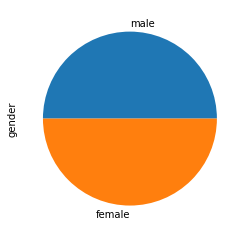

In [10]:
per_blogger.gender.value_counts().plot(kind="pie")

In [11]:
per_blogger.gender.value_counts(normalize=True)

male      0.5
female    0.5
Name: gender, dtype: float64

The blogger gender breakdown is 50-50. This was probably the choice of the dataset's creators.

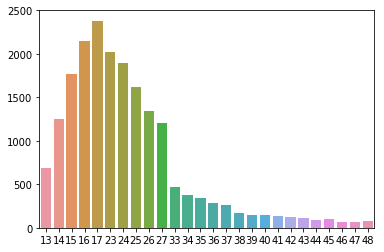

In [30]:
ages = list(set(per_blogger.age))
y = [per_blogger.age[per_blogger.age==x].count() for x in ages]
sns.barplot(x=ages, y=y)

So pretty! Seems like the largest group is 17 year olds. There is a pretty strong positive skew to the graph. One weird thing: there are no bloggers between 17 and 23. I don't quite understand how that could happen considering there are 19320 bloggers.

In [32]:
per_blogger.age.describe()

count    19320.000000
mean        22.833799
std          7.975490
min         13.000000
25%         16.000000
50%         23.000000
75%         26.000000
max         48.000000
Name: age, dtype: float64

Average age is ~23.

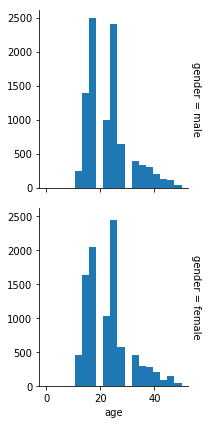

In [34]:
g = sns.FacetGrid(per_blogger, row="gender", margin_titles=True)
bins = np.linspace(0, 50, 20)
g.map(plt.hist, "age", bins=bins)

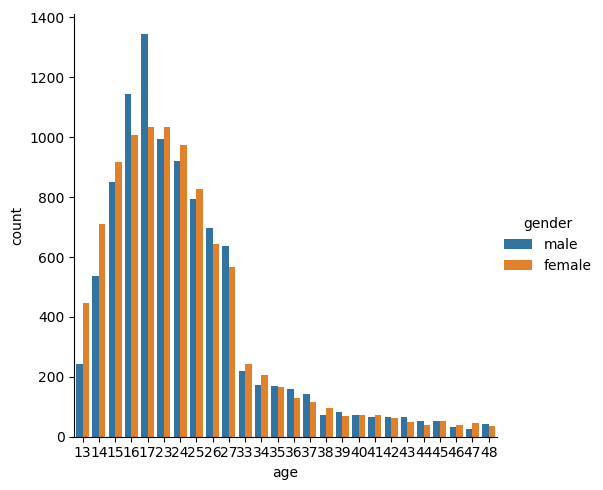

In [150]:
sns.catplot(x="age", hue="gender",
            kind="count", data=per_blogger)

When broken down by gender, the age distribution appears pretty similar.

In [40]:
per_blogger.industry.value_counts()

indUnk                     6827
Student                    5120
Education                   980
Technology                  943
Arts                        721
Communications-Media        479
Internet                    397
Non-Profit                  372
Engineering                 312
Government                  236
Law                         197
Consulting                  191
Science                     184
Marketing                   180
BusinessServices            163
Publishing                  150
Advertising                 145
Religion                    139
Telecommunications          119
Military                    116
Banking                     112
Accounting                  105
Fashion                      98
Tourism                      94
HumanResources               94
Transportation               91
Sports-Recreation            90
Manufacturing                87
Architecture                 69
Chemicals                    62
Biotech                      57
LawEnfor

There's a lot of industry options. As mentioned before, the plurality of bloggers did not list their industry.

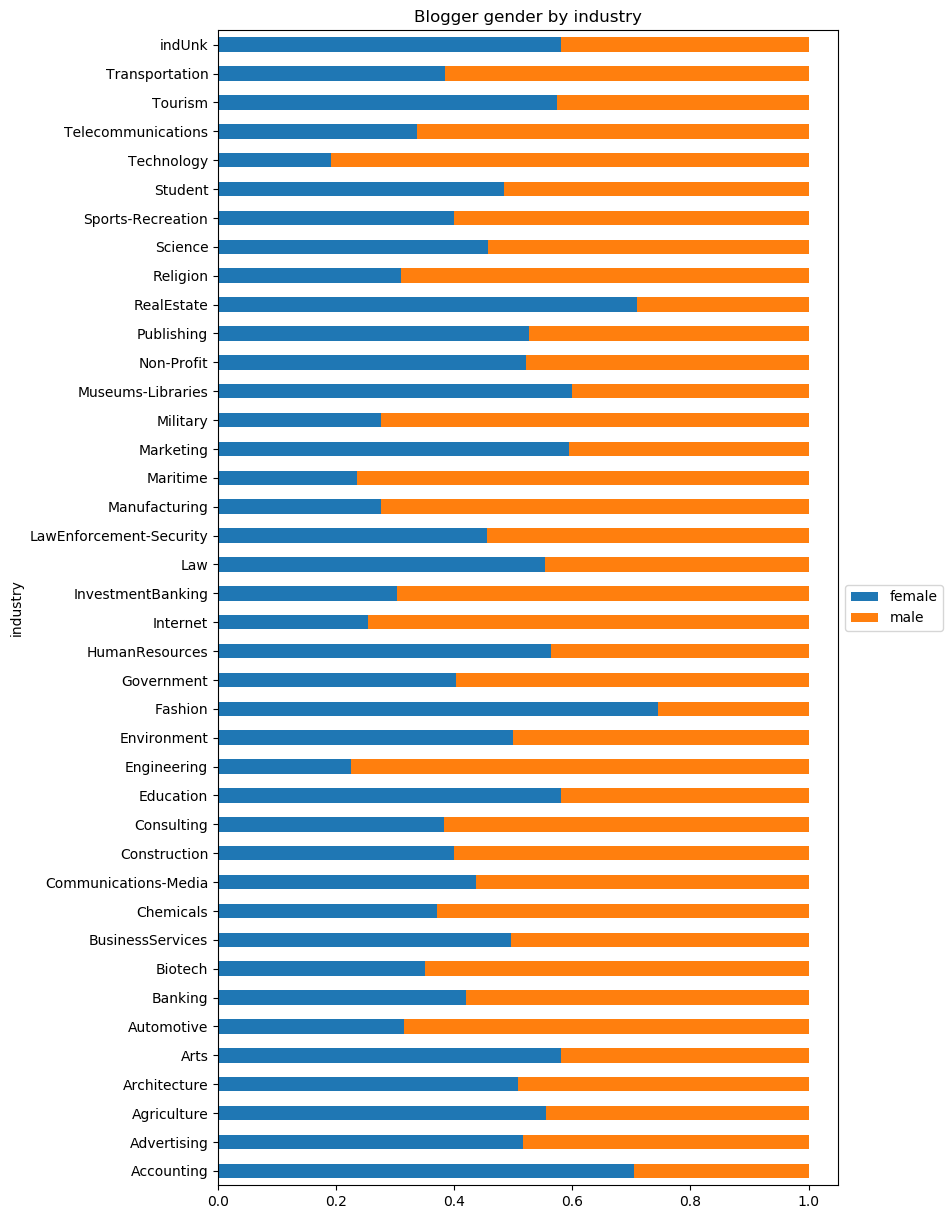

In [92]:
industry_by_gender = per_blogger.groupby('industry').gender.value_counts(normalize=True)
industry_by_gender.unstack(level=1).plot.barh(figsize=(8,15), stacked=True, title="Blogger gender by industry")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The above graph shows the gender breakdown by industry. Technology and engineering appear to be the most male-dominated industries, while real estate, fashion, and accounting all appear to be majority female.

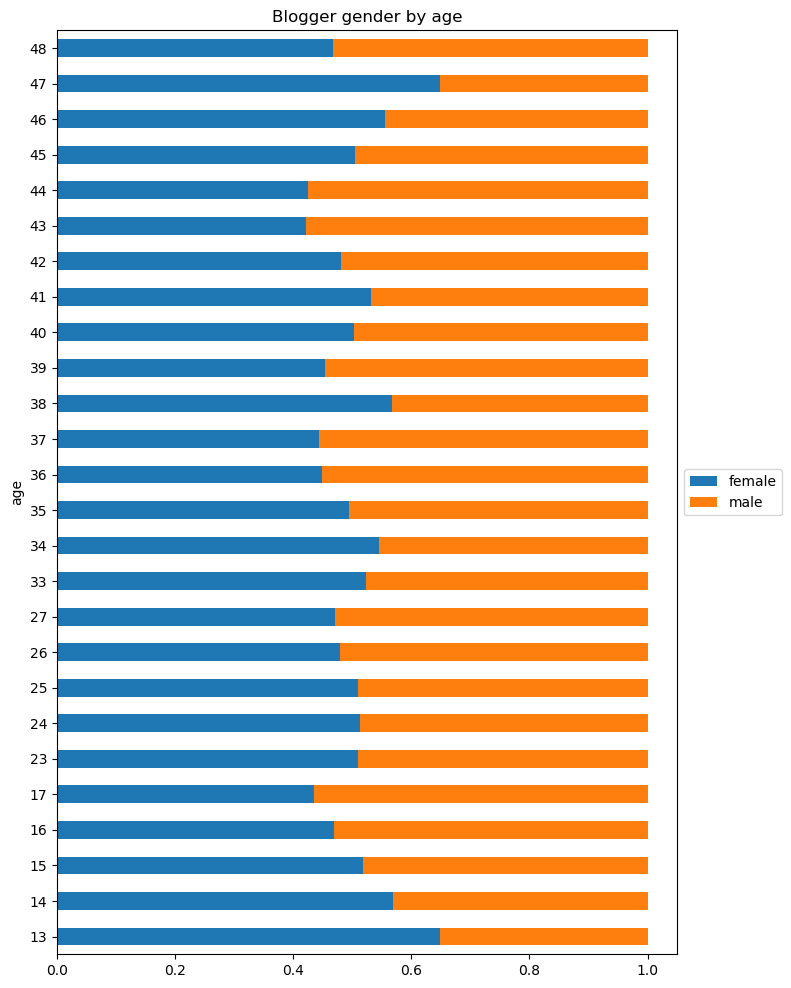

In [93]:
age_by_gender = per_blogger.groupby('age').gender.value_counts(normalize=True)
age_by_gender.unstack(level=1).plot.barh(figsize=(8,12), stacked=True, title="Blogger gender by age")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The above graph shows the gender breakdown by age. 

# Data analysis
### Goals of my analysis
There are three things I would like to investigate in this data. 
1. Word frequencies
2. Blog topics
3. Blog sentiment

In this section, I will begin investigating the first two, and hopefully get an idea of analyses to further explore. I didn't manage to get to blog sentiment in this progress report, so I'll save that for progress report 3.
## Data analysis: Word frequencies

### Methods
First, I'll tokenize all the blogs. Then I'll use NLTK to build some frequency distributions.

In [74]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
blogdata['tokens'] = blogdata.text.map(tokenizer.tokenize)

In [75]:
blogdata.head()

,id,gender,age,industry,sign,date,text,tokens
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","[Info, has, been, found, 100, pages, and, 4, 5..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,"[These, are, the, team, members, Drewes, van, ..."
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,"[In, het, kader, van, kernfusie, op, aarde, MA..."
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,"[testing, testing]"
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,"[Thanks, to, Yahoo, s, Toolbar, I, can, now, c..."


In [76]:
example_fd = nltk.FreqDist(blogdata.tokens[0])

In [77]:
example_fd.most_common(10)

[('has', 2), ('and', 2), ('Info', 1), ('been', 1), ('found', 1), ('100', 1), ('pages', 1), ('4', 1), ('5', 1), ('MB', 1)]

I tried making some conditional frequency distributions using industry, but it seems the code from the [NLTK book](http://www.nltk.org/book_1ed/ch02.html) doesn't work anymore. (Or maybe I'm just doing it wrong.) I'm going to try a different method to compare word frequencies across groups.
### Trying out frequency with Counter

In [83]:
from collections import Counter

In [84]:
minidf = blogdata.head(3)

In [85]:
minidf

,id,gender,age,industry,sign,date,text,tokens
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","[Info, has, been, found, 100, pages, and, 4, 5..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,"[These, are, the, team, members, Drewes, van, ..."
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,"[In, het, kader, van, kernfusie, op, aarde, MA..."


In [86]:
def Testing(df, column):
    for category in set(df[column].values):
        cnt = Counter()
        for blog in df[df[column]==category].tokens:
            for word in blog:
                cnt[word] += 1
        return cnt.most_common(10)

In [87]:
m = Testing(minidf, 'industry')

In [88]:
pd.DataFrame(m).set_index(0)

,1
0,
the,197
to,127
of,119
a,117
and,91
you,75
is,63
in,57
it,56


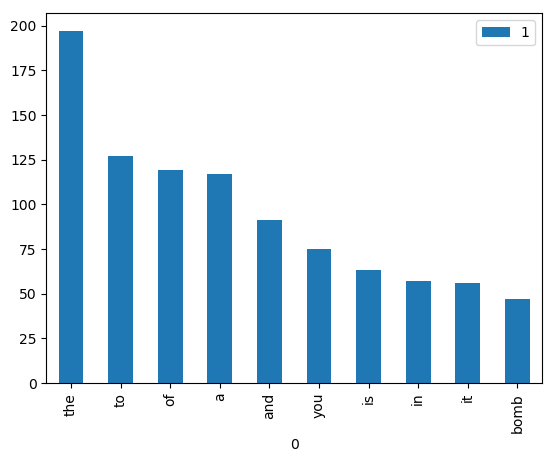

In [89]:
pd.DataFrame(m).set_index(0).plot(kind='bar')

That worked! Now let's do that for all the blogs.

### Most frequent words per industry

In [151]:
def Top10CategoryWords(df, column):
    # find top 10 words for each category in a column and plot
    ax_count = 0
    fig, axes = plt.subplots(len(set(df[column].values)), 1)
    for category in set(df[column].values):
        cnt = Counter()
        for blog in df[df[column]==category].tokens:
            for word in blog:
                cnt[word] += 1
        pd.DataFrame(cnt.most_common(10)).set_index(0).plot(kind='bar', 
                                                            figsize=(6,6*len(set(df[column].values))), 
                                                            ax=axes[ax_count], 
                                                            title='Top 10 most frequent words for ' + category)
        ax_count += 1

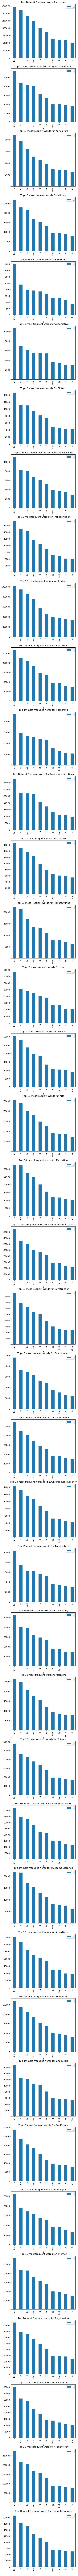

In [152]:
Top10CategoryWords(blogdata, 'industry')

Many of the Top 10 words across industry seem pretty similar, since they're articles/pronouns/prepositions. This long list of graphs is also difficult to read. Next time I would like to figure out how to incorporate feature weights. 

## Data analysis: Topic clustering
I would like to look at what topics are discussed in different blogs, and whether those topics vary according to demographic group. I imagine the topics will be have clear differences when grouped by blogger industry, though even within industry blogs may vary widely - just because two people both work in "Banking" does not mean they both blog about banking.

I did not originally intend to look at blog topics, but I have been reading a lot about topic modelling and it is really interesting to me. I wanted to give it a try using this data.
### Methods
I have absolutely no interest in going through all or even a portion of the 681,000 blogs in this dataset and hand-labelling them for topics. So, supervised learning is not going to work here. I am going to try my hand at unsupervised learning. Specifically, I am going to try **Latent Dirichlet allocation (LDA)** using scikit-learn. LDA performs topic detection on large, unlabelled document sets. In order to use LDA, I need to convert the texts to vectors. 

I learned this model from the DataCamp project ["The Hottest Topics in Machine Learning"](https://projects.datacamp.com/projects/158). I edited the code in that tutorial to fit my own data.

**FULL DISCLOSURE: I actually did this first, before anything else in the document. I went on to do some things later (chronologically) but technically now earlier. I am leaving in my first attempt for reference. (Mostly my own reference.)**

### Preprocessing the data
First, I'm going to remove punctuation and lowercase all blog texts. Then, I will convert the blog texts into vectors.

In [6]:
print(blogdata['text'].head())

0               Info has been found (+/- 100 pages,...
1               These are the team members:   Drewe...
2               In het kader van kernfusie op aarde...
3                     testing!!!  testing!!!          
4                 Thanks to Yahoo!'s Toolbar I can ...
Name: text, dtype: object


In [7]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
# Remove punctuation
blogdata['text_processed'] = blogdata['text'].map(lambda x: re.sub('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', x))

# Lowercase
blogdata['text_processed'] = blogdata['text_processed'].map(lambda x: x.lower())

# Remove extra white space. Not sure if it messes with the vectorization process in any way but just to be sure
blogdata['text_processed'] = blogdata['text_processed'].map(lambda x: ' '.join(x.split()))

print(blogdata['text_processed'].head())

0    info has been found 100 pages and 45 mb of pdf...
1    these are the team members drewes van der laag...
2    in het kader van kernfusie op aarde maak je ei...
3                                      testing testing
4    thanks to yahoos toolbar i can now capture the...
Name: text_processed, dtype: object


In [13]:
# I originally did this with CountVectorizer but it didn't load, leaving this code in just in case

# from sklearn.feature_extraction.text import CountVectorizer
# Create count vectorizer with English stop words
# count_vectorizer = CountVectorizer(max_features=500, stop_words = "english")
# blog_vec = count_vectorizer.fit_transform(blogdata['text_processed'])

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features = 1500, stop_words='english') 

### First try: topic clustering

In [10]:
blog_tfidf = tfidf_vectorizer.fit_transform(blogdata['text_processed'])

In [11]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, tfidf_vectorizer, n_top_words):
    words = tfidf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Picking number of topics and number of words
number_topics = 50
number_words = 5

lda = LDA(n_components=number_topics)
lda.fit(blog_tfidf)

Topics found via LDA:


NameError: name 'count_vectorizer' is not defined

In [12]:
print("Topics found via LDA:")
print_topics(lda, tfidf_vectorizer, number_words)

Topics found via LDA:

Topic #0:
na la ko sa da

Topic #1:
snow exam weather ben cold

Topic #2:
youre dont like im just

Topic #3:
urllink google search information art

Topic #4:
dont im just know want

Topic #5:
love life know heart just

Topic #6:
school class im teacher just

Topic #7:
book read books reading im

Topic #8:
pm break spring im ah

Topic #9:
site urllink page web website

Topic #10:
wedding beach im apartment lake

Topic #11:
baby women dave child woman

Topic #12:
god jesus lord life christ

Topic #13:
birthday happy party day im

Topic #14:
dun den juz wat tt

Topic #15:
movie movies film watch urllink

Topic #16:
test don questions ve question

Topic #17:
car road bike just driving

Topic #18:
hair black color red like

Topic #19:
hello dance kiss fly say

Topic #20:
im boring nick going really

Topic #21:
dad mom im paul just

Topic #22:
bush urllink kerry war president

Topic #23:
dog photos dogs concert tickets

Topic #24:
lol im like ur gonna

Topic #25:
bye w

Some topics and my thoughts:

+ **Topic #11: baby women dave child woman**
  + What. What is this.
+ **Topic #12: god jesus lord life christ**
  + Found the Christian bloggers.
+ **Topic #14: dun den juz wat tt**
  + I *think* this might actually be early 2000s textspeak, and I am super excited the model clustered these together.
+ **Topic #17: car road bike just driving**
  + ... transportation bloggers?
+ **Topic #20: im boring nick going really** & also **Topic #21: dad mom im paul just**
  + Here's what confuses me: Some of these have NAMES in them. How is that possible? How can the model cluster 682k blogs and have top words include people's names? Maybe I should find some way to exclude names from the data, because they might be clustering blogs that otherwise have nothing to do with each other.
+ **Topic #22: bush urllink kerry war president**
  + Found the political bloggers.
+ **Topic #23: dog photos dogs concert tickets**
  + These bloggers live a simple life: they love dogs and concerts. I respect that.
+ **Topic #24: lol im like ur gonna**
  + More! teen! bloggers! (I think.)
+ **Topic #27: fucking fuck shit im like**
  + People who curse a lot!
+ **Topic #30: eyes like just sun sky**
  + Poets?
+ **Topic #38: ha haha hi im oh**
  + More teens? Adults who use haha too much? 
+ **Topic #39: cheese 12 chocolate cream like**
  + Found the food bloggers.
+ **Topic #47: sleep im bed tired night**
  + Me currently. Also probably me in 2004.
  
#### Things I should change

I'm going to hold on off on changing the model / preprocessed text, since that took around 35 minutes to load and made my computer approximately twice as hot as the sun. But when I re-do this, I will: remove urllink, since it is not useful; use a better tokenizer, there are way too many tokens of "im"; figure out if I can remove non-English text without completely removing multilingual blogs. One cluster seems to be entirely non-English blogs: **Topic #0:
na la ko sa da***.

### Second try: Translating non-English blogs* and reducing the number of topics
*Please pretend this doesn't affect word frequency at all.

The first translator I am going to try is googletrans, which uses Google translator. We'll test on blog #2. This blog starts with ... Dutch? But is mostly English. From personal experience, it seems that when I try to translate English + another language into English using Google translate, it just all comes out being English. Let's see.

In [109]:
# it's a long one so I'm just printing this
blogdata.text[2][:300]

'           In het kader van kernfusie op aarde:  MAAK JE EIGEN WATERSTOFBOM   How to build an H-Bomb From: ascott@tartarus.uwa.edu.au (Andrew Scott) Newsgroups: rec.humor Subject: How To Build An H-Bomb (humorous!) Date: 7 Feb 1994 07:41:14 GMT Organization: The University of Western Australia  Orig'

In [117]:
from googletrans import Translator
translator = Translator()
x = translator.translate('In het kader van kernfusie op aarde:  MAAK JE EIGEN WATERSTOFBOM')

In [118]:
x.text

'In the context of fusion on earth: MAKE YOUR OWN HYDROGEN BOMB'

In [153]:
blog2sents = blogdata.text[2].split('.')

In [155]:
blog2sents[0]

'           In het kader van kernfusie op aarde:  MAAK JE EIGEN WATERSTOFBOM   How to build an H-Bomb From: ascott@tartarus'

In [156]:
translator.translate(blog2sents[0])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

I am having a lot of trouble with this one. I can't get translator.detect() to work at all. I haven't found many other translators that don't depend on Google translate. Now I'm going to try NLTK's textcat.

In [160]:
from nltk.classify import textcat
tc = textcat.TextCat()

OSError: classify.textcat requires the regex module that supports unicode. Try '$ pip install regex' and see https://pypi.python.org/pypi/regex for further details.

Ok so.... I installed regex... and it's still not working. I think I am going to give up for now.
### Third try: Reducing the number of topics

In [163]:
# I'm reimporting these bc I don't want to reload the kernel
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features = 1500, stop_words='english') 

# I realize now there was no need to take out punctuation before
blog_tfidf = tfidf_vectorizer.fit_transform(blogdata['text'])

In [164]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, tfidf_vectorizer, n_top_words):
    words = tfidf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Picking number of topics and number of words
number_topics = 20
number_words = 3

lda = LDA(n_components=number_topics)
lda.fit(blog_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [165]:
print("Topics found via LDA:")
print_topics(lda, tfidf_vectorizer, number_words)

Topics found via LDA:

Topic #0:
blog post just

Topic #1:
car phone just

Topic #2:
game team birthday

Topic #3:
urllink nbsp brought

Topic #4:
went got night

Topic #5:
god church jesus

Topic #6:
like just hair

Topic #7:
movie night just

Topic #8:
nbsp urllink 2004

Topic #9:
urllink book people

Topic #10:
im dont lol

Topic #11:
class school test

Topic #12:
just don know

Topic #13:
na just like

Topic #14:
urllink com http

Topic #15:
urllink bush war

Topic #16:
love life like

Topic #17:
going just fun

Topic #18:
haha la den

Topic #19:
music song urllink


I forgot to take out urllink again! Oops. It's still weird to me that many of the categories have overlapping words, for example "just" in topics 0, 1, 6, 7, 13, and 17. Maybe next time I should try a different topic modelling algorithm.

## Conclusions

I think this was a good start to my analysis. In my next progress report, I hope to find a more informative way to look at word frequencies, perhaps using TF-IDF. I would also like to investigate other ways to do topic modelling. Next time, I will also get started on sentiment analysis.